To build the model for TC.

In [1]:
import numpy as np 
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Launch deployment

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    project="aslee@10.110.16.5",
    queue='main',
    cores=20, 
    memory='10 GB',
    walltime="00:20:00",
    log_directory='job_logs'
)

In [21]:
client.close()
cluster.close()

In [7]:
client = Client(cluster)
cluster.scale(150)
#cluster.adapt(maximum=100)

In [8]:
client

Client Scheduler: tcp://10.110.16.11:44025 Dashboard: http://10.110.16.11:8787/status,Cluster Workers: 44 Cores: 176 Memory: 88.00 GB


# Build model for TC

In [9]:
from dask_ml.model_selection import train_test_split
merge_df = dd.read_csv('data/spe+bulk_dataset_20201008.csv')
X = merge_df.iloc[:, 1: -5].to_dask_array(lengths=True)
X = X / X.sum(axis = 1, keepdims = True)
y = merge_df['TC%'].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

In [13]:
y_ttest = np.array(y_test)
y_ttrain = np.array(y_train)

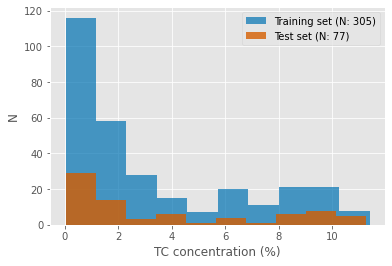

In [15]:
plt.hist(y_ttrain, alpha=.7, label='Training set (N: {})'.format(len(y_ttrain)))
plt.hist(y_ttest, color='C2', alpha=.8, label='Test set (N: {})'.format(len(y_ttest)))
plt.xlabel('TC concentration (%)')
plt.ylabel('N')
plt.legend()
plt.savefig('results/tc_histogram_{}.png'.format(date))

## Grid search
We know the relationship between the spectra and bulk measurements might not be linear; and based on the pilot_test.ipynb, the SVR algorithm with NMF transformation provides the better cv score. So we focus on grid search with NMF transformation (4, 5, 6 and 7 components based on the PCA result) and SVR.

In [10]:
%%time
from dask_ml.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(max_iter = 2000, random_state = 24), SVR())
params = {
    'nmf__n_components': [4, 5, 6, 7],
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-5, 0, 6)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 10, n_jobs = -1)  

grid.fit(X_train, y_train)

print('The best cv score: {:.3f}'.format(grid.best_score_)) 
print('The test score: {:.3f}'.format(grid.best_estimator_.score(X_test, y_test)))
print('The best model\'s parameters: {}'.format(grid.best_estimator_))

The best cv score: 0.972
The test score: 0.958
The best model's parameters: Pipeline(steps=[('nmf', NMF(max_iter=2000, n_components=6, random_state=24)),
                ('svr', SVR(C=100000.0, gamma=1.0))])
CPU times: user 11.6 s, sys: 516 ms, total: 12.1 s
Wall time: 19.4 s


In [11]:
y_predict = grid.best_estimator_.predict(X_test)
y_ttest = np.array(y_test)

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
print('Scores in the test set:')
print('The mean absolute error is {:.3f} (%, concetration).'.format(mean_absolute_error(y_ttest, y_predict)))
print('The max. residual error is {:.3f} (%, concetration).'.format(max_error(y_ttest, y_predict)))

Scores in the test set:
The mean absolute error is 0.449 (%, concetration).
The max. residual error is 3.386 (%, concetration).


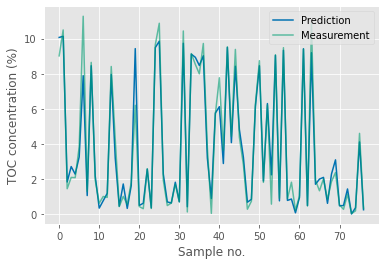

In [16]:
plt.plot(range(len(y_predict)), y_predict, label='Prediction')
plt.plot(range(len(y_predict)), y_ttest, alpha=0.6, label='Measurement')
plt.ylabel('TOC concentration (%)')
plt.xlabel('Sample no.')
plt.legend()
plt.savefig('results/tc_predictions_nmr+svr_{}.png'.format(date))

### Visualization

In [17]:
result_df = pd.DataFrame(grid.cv_results_)
result_df.to_csv('results/tc_gridsearch_nmf+svr_{}.csv'.format(date))
#result_df = pd.read_csv('results/gridsearch_nmf+svr_20201009.csv', index_col = 0)
#result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

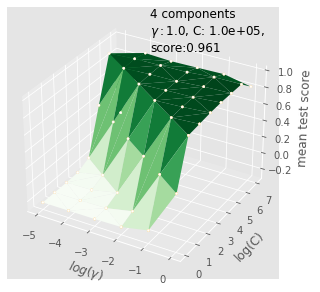

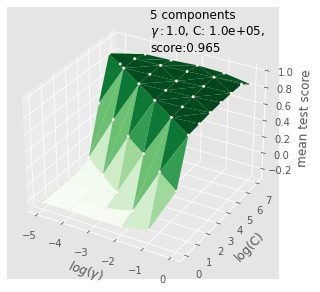

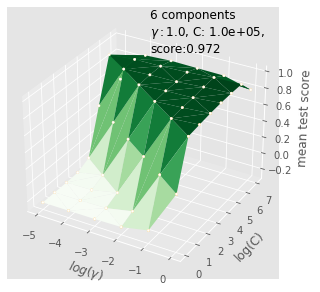

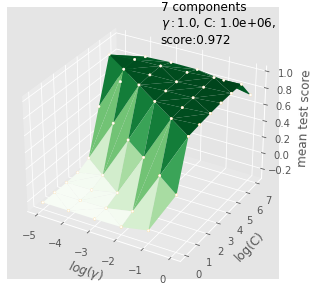

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for n_components in [4, 5, 6, 7]:
    data = result_df[result_df.param_nmf__n_components == n_components].reset_index(drop = True)
    fig = plt.figure(figsize = (7.3,5))
    ax = fig.gca(projection='3d')
    xx = data.param_svr__gamma.astype(float)
    yy = data.param_svr__C.astype(float)
    zz = data.mean_test_score.astype(float)
    max_index = np.argmax(zz)

    surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
    # mark the best score
    ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
    text = '{} components\n$\gamma :{:.1f}$, C: {:.1e},\nscore:{:.3f}'.format(n_components, xx[max_index], yy[max_index], zz[max_index])
    ax.text(np.log10(xx[max_index])-3, np.log10(yy[max_index]), 
            1.2,text,
            fontsize=12)

    ax.set_xlabel('$log(\gamma)$')
    ax.set_ylabel('log(C)')
    ax.set_zlabel('mean test score')
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    fig.savefig('results/grid_tc_{}nmr+svr_3D_{}.png'.format(n_components, date))

In [21]:
from joblib import dump, load
#model = load('models/tc_nmf+svr_model_20201012.joblib')
dump(grid.best_estimator_, 'models/tc_nmf+svr_model_{}.joblib'.format(date)) 

['models/tc_nmf+svr_model_20201012.joblib']

# Notes
After dealing with TOC, I have an idea. why not CaCO3, TC and TOC all use residuals as the error measure? Thiscould provide better consistency. But I think it's better to use R2 (i.e. coefficient of determination) for CaCO3 and TC, address the probelm found in TOC, and use the mean and max. absolute errors to describe TOC as an work-around. This is because R2 is more common, and the logic of using mean and max. absolute errors can be addressed more smoothly in this way.